In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Data

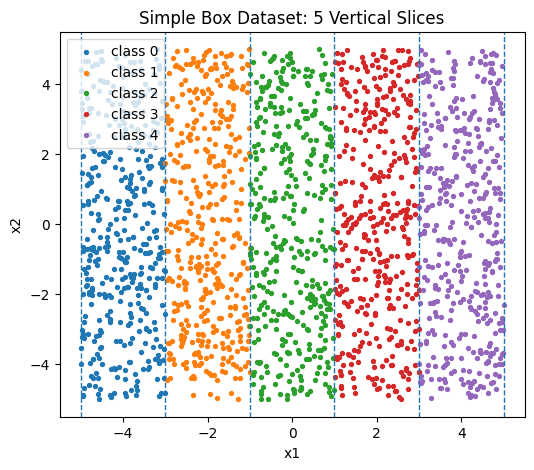

In [3]:
np.random.seed(0)

def make_box_5slices(N=2000, box_min=-5, box_max=5):
    # Uniform random points
    X = np.random.uniform(box_min, box_max, size=(N, 2))
    x = X[:, 0]

    # 5 equal slices in x direction
    edges = np.linspace(box_min, box_max, 6)  # 6 edges -> 5 slices

    # labels: 0..4 depending on slice
    y = np.zeros(N, dtype=int)
    for k in range(5):
        mask = (x >= edges[k]) & (x < edges[k+1])
        y[mask] = k

    # fix last edge inclusion
    y[x == box_max] = 4

    return X, y, edges

X_raw, y_raw, edges = make_box_5slices()

# Plot dataset (raw)
plt.figure(figsize=(6,5))
for k in range(5):
    plt.scatter(X_raw[y_raw==k,0], X_raw[y_raw==k,1], s=8, label=f"class {k}")
for e in edges:
    plt.axvline(e, linestyle="--", linewidth=1)  # show slice borders

plt.legend()
plt.title("Simple Box Dataset: 5 Vertical Slices")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [4]:
def train_test_split(X, y, test_ratio=0.25, seed=0):
    rng = np.random.default_rng(seed)
    idx = rng.permutation(len(X))
    n_test = int(len(X)*test_ratio)
    test_idx, train_idx = idx[:n_test], idx[n_test:]
    return X[train_idx], X[test_idx], y[train_idx], y[test_idx]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y_raw)

mu = X_train_raw.mean(axis=0)
sig = X_train_raw.std(axis=0)

X_train_std = (X_train_raw - mu) / sig
X_test_std  = (X_test_raw  - mu) / sig

In [5]:
class NeuralNetwork(object):

    def __init__(self, input_dim=2, h1=64, h2=32, h3=16, num_classes=5, lr=0.03, seed=1):
        rng = np.random.default_rng(seed)
        self.learning_rate = lr
        self.num_classes = num_classes

        # He initialization for ReLU layers
        self.W1 = rng.normal(0, np.sqrt(2/input_dim), size=(input_dim, h1))
        self.W2 = rng.normal(0, np.sqrt(2/h1),        size=(h1, h2))
        self.W3 = rng.normal(0, np.sqrt(2/h2),        size=(h2, h3))
        self.W4 = rng.normal(0, np.sqrt(2/h3),        size=(h3, num_classes))

        self.b1 = np.zeros((1, h1))
        self.b2 = np.zeros((1, h2))
        self.b3 = np.zeros((1, h3))
        self.b4 = np.zeros((1, num_classes))

    def relu(self, x, der=False):
        if der:
            return (x > 0).astype(float)
        return np.maximum(0, x)

    def softmax(self, x):
        # stable softmax
        x = x - np.max(x, axis=1, keepdims=True)
        expx = np.exp(x)
        return expx / np.sum(expx, axis=1, keepdims=True)

    def feedForward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = self.relu(self.z1)

        # Layer 2
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.a2 = self.relu(self.z2)

        # Layer 3
        self.z3 = np.dot(self.a2, self.W3) + self.b3
        self.a3 = self.relu(self.z3)

        # Output layer
        self.z4 = np.dot(self.a3, self.W4) + self.b4
        probs = self.softmax(self.z4)
        return probs

    def cross_entropy(self, probs, Y_onehot):
        eps = 1e-12
        return -np.mean(np.sum(Y_onehot * np.log(probs + eps), axis=1))

    def backPropagation(self, X, Y_onehot, probs):
        N = X.shape[0]

        # Output gradients (softmax + CE)
        dZ4 = probs - Y_onehot                              # (N, C)
        dW4 = np.dot(self.a3.T, dZ4) / N                    # (H3, C)
        db4 = np.sum(dZ4, axis=0, keepdims=True) / N

        # Hidden layer 3
        dA3 = np.dot(dZ4, self.W4.T)                        # (N, H3)
        dZ3 = dA3 * self.relu(self.z3, der=True)
        dW3 = np.dot(self.a2.T, dZ3) / N
        db3 = np.sum(dZ3, axis=0, keepdims=True) / N

        # Hidden layer 2
        dA2 = np.dot(dZ3, self.W3.T)
        dZ2 = dA2 * self.relu(self.z2, der=True)
        dW2 = np.dot(self.a1.T, dZ2) / N
        db2 = np.sum(dZ2, axis=0, keepdims=True) / N

        # Hidden layer 1
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * self.relu(self.z1, der=True)
        dW1 = np.dot(X.T, dZ1) / N
        db1 = np.sum(dZ1, axis=0, keepdims=True) / N

        # Gradient descent step
        lr = self.learning_rate
        self.W4 -= lr * dW4; self.b4 -= lr * db4
        self.W3 -= lr * dW3; self.b3 -= lr * db3
        self.W2 -= lr * dW2; self.b2 -= lr * db2
        self.W1 -= lr * dW1; self.b1 -= lr * db1

    def train_step(self, X, y_int):
        # One-hot using self.num_classes (no hardcoding)
        Y_onehot = np.eye(self.num_classes)[y_int]
        probs = self.feedForward(X)
        self.backPropagation(X, Y_onehot, probs)
        return self.cross_entropy(probs, Y_onehot)

    def predict(self, X):
        probs = self.feedForward(X)
        return np.argmax(probs, axis=1)

    def predict_proba(self, X):
        return self.feedForward(X)


# Train

Epoch   1 | loss=1.0752 | acc=0.5793
Epoch  25 | loss=0.1932 | acc=0.9460
Epoch  50 | loss=0.0977 | acc=0.9780
Epoch  75 | loss=0.0793 | acc=0.9760
Epoch 100 | loss=0.1445 | acc=0.9460
Epoch 125 | loss=0.0895 | acc=0.9640
Epoch 150 | loss=0.0469 | acc=0.9840
Epoch 175 | loss=0.1011 | acc=0.9660
Epoch 200 | loss=0.1179 | acc=0.9587
Epoch 225 | loss=0.0520 | acc=0.9753
Epoch 250 | loss=0.0449 | acc=0.9827


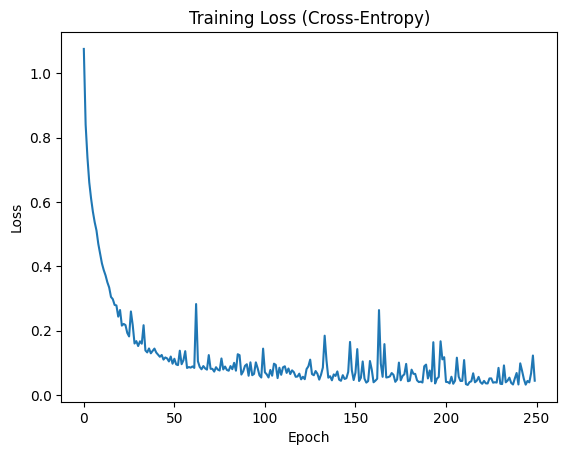

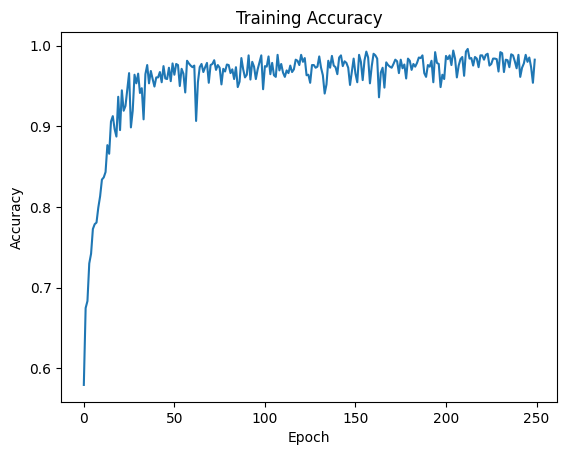

In [6]:
nn = NeuralNetwork(lr=0.03)

epochs = 250
batch_size = 64
loss_hist, acc_hist = [], []

N = X_train_std.shape[0]

for ep in range(1, epochs+1):
    perm = np.random.permutation(N)
    Xs = X_train_std[perm]
    ys = y_train[perm]

    for start in range(0, N, batch_size):
        xb = Xs[start:start+batch_size]
        yb = ys[start:start+batch_size]
        nn.train_step(xb, yb)

    probs_tr = nn.predict_proba(X_train_std)
    loss = nn.cross_entropy(probs_tr, np.eye(5)[y_train])
    pred_tr = np.argmax(probs_tr, axis=1)
    acc = np.mean(pred_tr == y_train)

    loss_hist.append(loss)
    acc_hist.append(acc)

    if ep % 25 == 0 or ep == 1:
        print(f"Epoch {ep:3d} | loss={loss:.4f} | acc={acc:.4f}")

plt.figure()
plt.plot(loss_hist)
plt.title("Training Loss (Cross-Entropy)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(acc_hist)
plt.title("Training Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

# Testing


Overall Test Accuracy: 0.98
Class 0: precision=1.000, recall=0.992, f1=0.996, support=121
Class 1: precision=0.989, recall=0.967, f1=0.978, support=92
Class 2: precision=0.967, recall=0.989, f1=0.978, support=89
Class 3: precision=0.990, recall=0.951, f1=0.970, support=103
Class 4: precision=0.950, recall=1.000, f1=0.974, support=95

Confusion Matrix:
 [[120   1   0   0   0]
 [  0  89   3   0   0]
 [  0   0  88   1   0]
 [  0   0   0  98   5]
 [  0   0   0   0  95]]


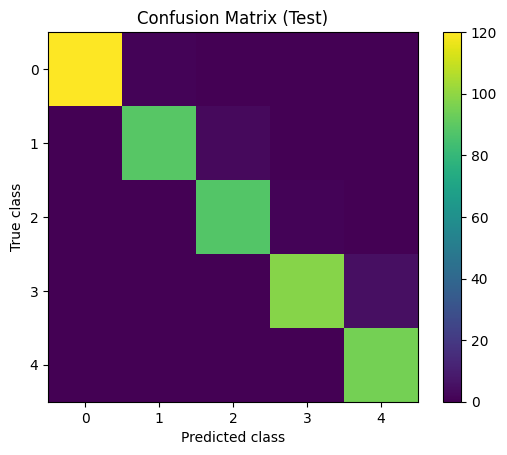

In [7]:
def confusion_matrix(y_true, y_pred, num_classes=5):
    cm = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def classification_report(y_true, y_pred, num_classes=5):
    report = {}
    for c in range(num_classes):
        tp = np.sum((y_true==c) & (y_pred==c))
        fp = np.sum((y_true!=c) & (y_pred==c))
        fn = np.sum((y_true==c) & (y_pred!=c))

        precision = tp/(tp+fp+1e-12)
        recall    = tp/(tp+fn+1e-12)
        f1        = 2*precision*recall/(precision+recall+1e-12)
        support   = np.sum(y_true==c)

        report[c] = (precision, recall, f1, support)

    overall_acc = np.mean(y_true==y_pred)
    return report, overall_acc

y_pred_test = nn.predict(X_test_std)
rep, test_acc = classification_report(y_test, y_pred_test)

print("\nOverall Test Accuracy:", test_acc)
for c,(p,r,f1,sup) in rep.items():
    print(f"Class {c}: precision={p:.3f}, recall={r:.3f}, f1={f1:.3f}, support={sup}")

cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix:\n", cm)

plt.figure()
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix (Test)")
plt.colorbar()
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.xticks(range(5))
plt.yticks(range(5))
plt.show()

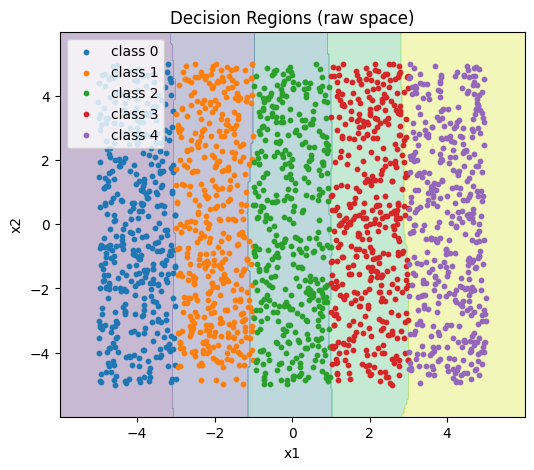

In [8]:
def plot_decision_regions_raw(model, X_raw, y_raw, mu, sig):
    x_min, x_max = X_raw[:,0].min()-1, X_raw[:,0].max()+1
    y_min, y_max = X_raw[:,1].min()-1, X_raw[:,1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min,x_max,300),
                         np.linspace(y_min,y_max,300))
    grid_raw = np.c_[xx.ravel(), yy.ravel()]
    grid_std = (grid_raw - mu)/sig  # standardize for model
    preds = model.predict(grid_std).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, preds, alpha=0.3)
    for k in range(5):
        plt.scatter(X_raw[y_raw==k,0], X_raw[y_raw==k,1], s=10, label=f"class {k}")
    plt.legend()
    plt.title("Decision Regions (raw space)")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.show()

plot_decision_regions_raw(nn, X_raw, y_raw, mu, sig)

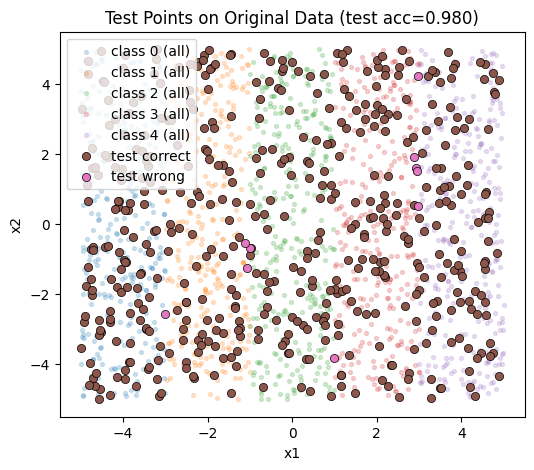

In [9]:
plt.figure(figsize=(6,5))

# original generated data (raw)
for k in range(5):
    plt.scatter(X_raw[y_raw==k,0], X_raw[y_raw==k,1], s=8, alpha=0.2, label=f"class {k} (all)")

# test points (raw) - green correct, red incorrect
correct = (y_pred_test == y_test)
plt.scatter(X_test_raw[correct,0], X_test_raw[correct,1],
            s=35, edgecolor="black", linewidth=0.5, label="test correct")
plt.scatter(X_test_raw[~correct,0], X_test_raw[~correct,1],
            s=35, edgecolor="black", linewidth=0.5, label="test wrong")

plt.title(f"Test Points on Original Data (test acc={test_acc:.3f})")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.show()
